### Setup

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os.path
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
import matplotlib.pyplot as plt 

### Read Simulation Outputs 

In [5]:
input_file = '/Users/Ismael/temp_data/final_fits1.fits'
data = fits.open(input_file)
cat = astropy.table.Table.read(data,hdu=1)

In [10]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

#filter duplicates and rare(bad) objs. Which will not be good for our purposes. 
not_bad = lambda cat: cat[(cat['snr_grp'] != 0) & (cat['ds_grp']!= inf) ]

In [6]:
def get_non_duplicated_cat(cat):
    #get non-duplicated and duplicated objects
    seen = set()
    duplic = set()
    a = list(cat['db_id'])

    for x in a:
        if x in seen: 
            duplic.add(x)
        if x not in seen:
            seen.add(x)

    #get duplicated objects
    duplic_bool = []
    non_duplic_bool = []
    for x in list(cat['db_id']):
        if x in duplic:
            duplic_bool.append(True)
            non_duplic_bool.append(False)
        else:
            duplic_bool.append(False)
            non_duplic_bool.append(True)
            
    duplic_cat = cat[np.array(duplic_bool)]
    non_duplic_cat = cat[np.array(non_duplic_bool)]  #decided to just remove duplicated 
    
    return non_duplic_cat

In [8]:
def leaveRandom(sz,cat):
    new_cat = deepcopy(cat)
    rm_rows = random.sample(xrange(0,len(cat)-1), len(cat) - sz)
    new_cat.remove_rows(rm_rows)
    return new_cat 

In [9]:
#get a smaller sample of each of the catalogs for illustrative purposes 
N = 10000
cat_small = leaveRandom(N, cat)
good_small = leaveRandom(N, good)
gold_small = leaveRandom(N, gold)

### Comparing unblended and blended biases with a histogram. 

In [22]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_plots(cat,good,gold,save=None):
    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 2,3
    #
    plt.subplot(nrow, ncol, 1) 
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1')
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color='red',histtype='step',label='bias_g1_grp')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on g1 for all galaxies',fontsize=14)
    plt.xlabel('bias on g1',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    #
    plt.subplot(nrow, ncol, 2) 
    plt.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1')
    plt.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,color='red',histtype='step',label='bias_g1_grp')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on g1 for good galaxies',fontsize=14)
    plt.xlabel('bias on g1 ',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    #
    plt.subplot(nrow, ncol, 3) 
    plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1')
    plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='red',histtype='step',label='bias_g1_grp')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on g1 for gold galaxies',fontsize=14)
    plt.xlabel('bias on g1',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    #
    plt.subplot(nrow, ncol, 4) 
    plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2')
    plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,color='red',histtype='step',label='bias_g2_grp')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on g2 for all galaxies',fontsize=14)
    plt.xlabel('bias on g2',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    #
    plt.subplot(nrow, ncol, 5) 
    plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2')
    plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='red',histtype='step',label='bias_g2_grp')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on g2 for good galaxies',fontsize=14)
    plt.xlabel('bias on g2',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    #
    plt.subplot(nrow, ncol, 6) 
    plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2')
    plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='red',histtype='step',label='bias_g2_grp')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on g2 for gold galaxies',fontsize=14)
    plt.xlabel('bias on g2',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)



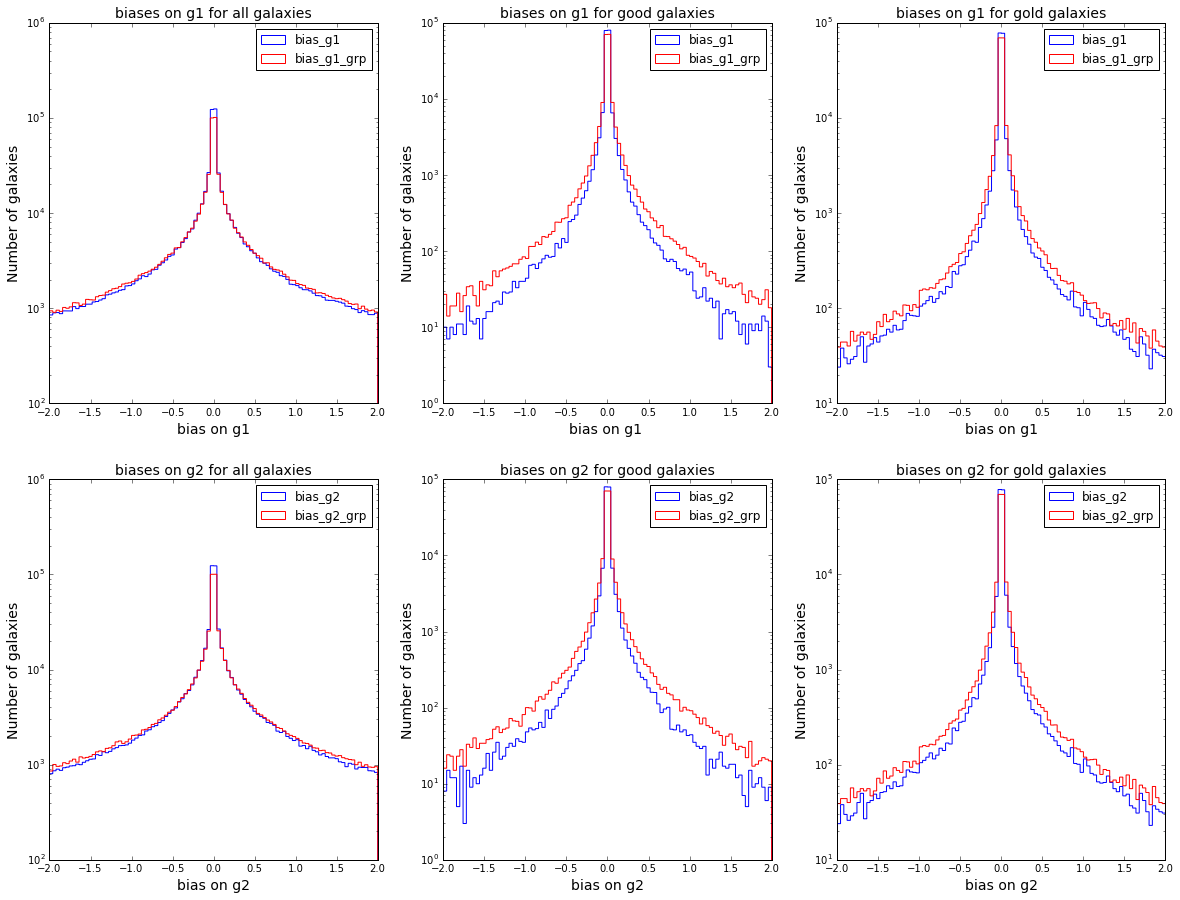

In [23]:
shear_biases_plots(cat,good,gold)

### Comparing unblended and blended biases with a histogram. v2

In [21]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_plots2(cat,good,gold,save=None):
    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 2,1
    #
    plt.subplot(nrow, ncol, 1) 
#     plt.title('biases on g1 galaxies',fontsize=14)
    plt.xlabel('bias on g1',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.xticks(size=16)
    plt.yticks(size=16)
#     plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_all',color='red',weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g1_grp_all',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_good',color='blue',weights=np.ones_like(good['bias_g1'])/len(good['bias_g1']))
    plt.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='blue',histtype='step',label='bias_g1_grp_good',weights=np.ones_like(good['bias_g1_grp'])/len(good['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(gold['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g1_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g1']))
    plt.hist(gold['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='gold',histtype='step',label='bias_g1_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g1_grp']))
    plt.legend(prop={'size':15})
    plt.yscale('log')
    #
    #
    plt.subplot(nrow, ncol, 2) 
    plt.tick_params(axis='both', which='minor',size=5)
    plt.title('biases on g2',fontsize=14)
    plt.xlabel('bias on g2',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    #
    plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_all',color='red',weights=np.ones_like(cat['bias_g2'])/len(cat['bias_g2']))
    plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g2_grp_all',weights=np.ones_like(cat['bias_g2_grp'])/len(cat['bias_g2_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_good',color='blue',weights=np.ones_like(good['bias_g2'])/len(good['bias_g2']))
    plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='blue',ls='dashed',histtype='step',label='bias_g2_grp_good',weights=np.ones_like(good['bias_g2_grp'])/len(good['bias_g2_grp']))
    plt.legend()
    #
    plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g2_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g2']))
    plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='gold',ls='dashed',histtype='step',label='bias_g2_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g2_grp']))
    plt.legend()
    plt.yscale('log')

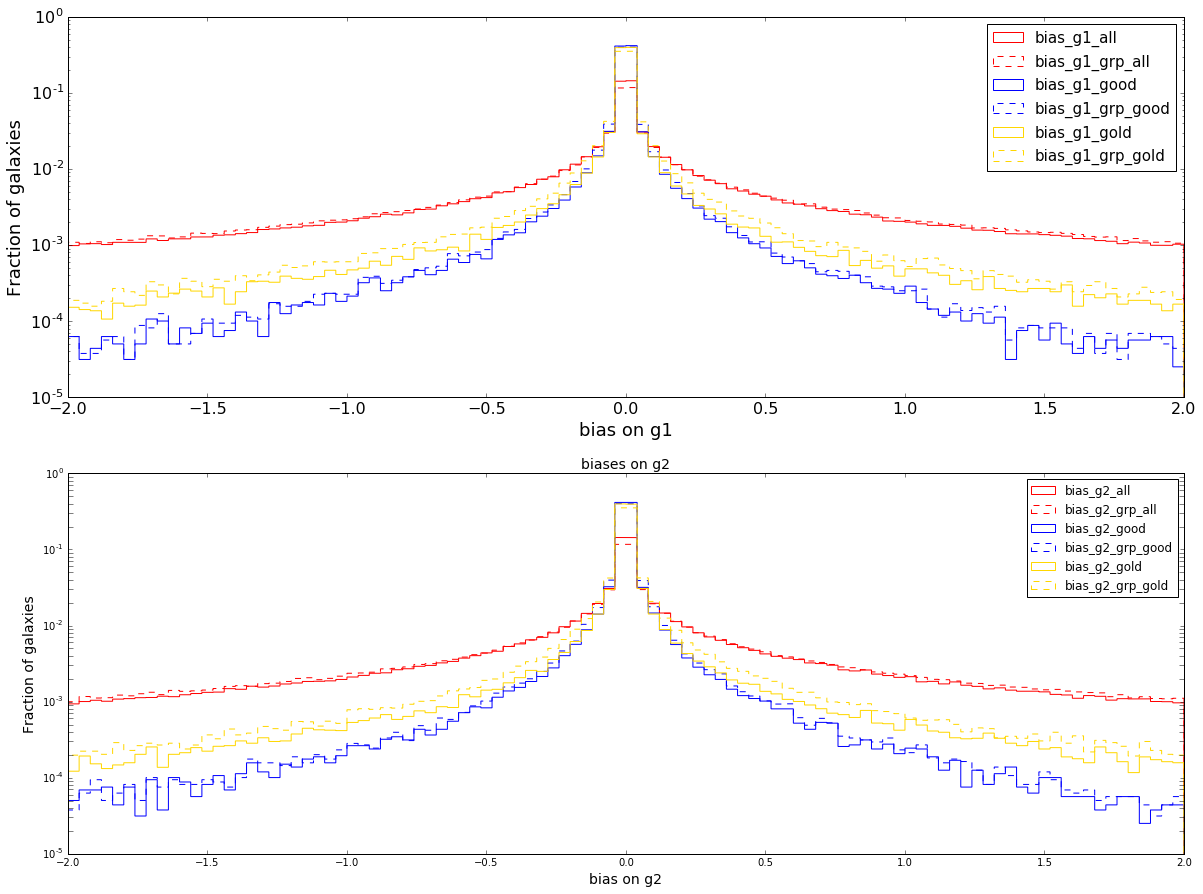

In [22]:
shear_biases_plots2(cat,good(cat),gold(cat))

### Covariance of biases  

In [20]:
#some plot from the notebook ShearEstimatorPlots using biases from the Fisher Formalism. 
#made a cut on biases for g1 and g2 in range (-2,2)
def purity_bias_shears(cat,good, gold, save=None):
    selected_cat = (cat['bias_g1'] < 2.) & (cat['bias_g1'] > -2.) & (cat['bias_g2'] < 2.) & (cat['bias_g2'] > -2.) #makes plot more feasible
    selected_good = (good['bias_g1'] < 2.) & (good['bias_g1'] > -2.) & (good['bias_g2'] < 2.) & (good['bias_g2'] > -2.)
    selected_gold = (gold['bias_g1'] < 2.) & (gold['bias_g1'] > -2.) & (gold['bias_g2'] < 2.) & (gold['bias_g2'] > -2.)
    selected_cat_grp = (cat['bias_g1_grp'] < 2.) & (cat['bias_g1_grp'] > -2.) & (cat['bias_g2_grp'] < 2.) & (cat['bias_g2_grp'] > -2.) #makes plot more feasible
    selected_good_grp = (good['bias_g1_grp'] < 2.) & (good['bias_g1_grp'] > -2.) & (good['bias_g2_grp'] < 2.) & (good['bias_g2_grp'] > -2.)
    selected_gold_grp = (gold['bias_g1_grp'] < 2.) & (gold['bias_g1_grp'] > -2.) & (gold['bias_g2_grp'] < 2.) & (gold['bias_g2_grp'] > -2.)
    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 3,2
    #
    plt.subplot(nrow,ncol,1)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat[selected_cat]['purity'] >= xlo) & (cat[selected_cat]['purity'] < xhi)
        dg1 = cat[selected_cat]['bias_g1'][in_range]
        dg2 = cat[selected_cat]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.1,.6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    ##
    plt.tight_layout()

    #
    
    plt.subplot(nrow,ncol,2)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat[selected_cat_grp]['purity'] >= xlo) & (cat[selected_cat_grp]['purity'] < xhi)
        dg1 = cat[selected_cat_grp]['bias_g1_grp'][in_range]
        dg2 = cat[selected_cat_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.1,.6)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.axhline(0,color='green')
    ##
    plt.tight_layout()
    #
    
    
    plt.subplot(nrow,ncol,3)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (good[selected_good]['purity'] >= xlo) & (good[selected_good]['purity'] < xhi)
        dg1 = good[selected_good]['bias_g1'][in_range]
        dg2 = good[selected_good]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.axhline(0,color='green')


    ##
    plt.tight_layout()
    #
    plt.subplot(nrow,ncol,4)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (good[selected_good_grp]['purity'] >= xlo) & (good[selected_good_grp]['purity'] < xhi)
        dg1 = good[selected_good_grp]['bias_g1_grp'][in_range]
        dg2 = good[selected_good_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    #
    
    plt.subplot(nrow,ncol,5)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (gold[selected_gold]['purity'] >= xlo) & (gold[selected_gold]['purity'] < xhi)
        dg1 = gold[selected_gold]['bias_g1'][in_range]
        dg2 = gold[selected_gold]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    #
    
    
    plt.subplot(nrow,ncol,6)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (gold[selected_gold_grp]['purity'] >= xlo) & (gold[selected_gold_grp]['purity'] < xhi)
        dg1 = gold[selected_gold_grp]['bias_g1_grp'][in_range]
        dg2 = gold[selected_gold_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    

[ 0.56923227  0.54885199  0.5208669   0.51751078  0.50052466  0.48002578
  0.46431885  0.44841109  0.43143654  0.41445088  0.40381259  0.36837983]
[ 0.5662742   0.54438797  0.52182285  0.50787482  0.49781253  0.48276325
  0.46159505  0.44856632  0.43850508  0.41118325  0.40432554  0.370529  ]
[-0.00319381  0.00548286 -0.01693667  0.01416484 -0.01024343 -0.00100715
  0.01513102  0.01586185 -0.01976583 -0.0062112  -0.01163866  0.00136552]
[ 0.70241724  0.65933356  0.64017186  0.61664105  0.58742419  0.55498135
  0.52332776  0.51042805  0.48441092  0.44444804  0.42003282  0.37097084]
[ 0.70714348  0.66055672  0.64410487  0.60556212  0.58863687  0.55888994
  0.52930625  0.51186687  0.49080462  0.44420445  0.42104832  0.37447799]
[ 0.007554   -0.00237106  0.00249385 -0.00108469 -0.01041093  0.01886788
  0.00034749 -0.00411663 -0.01179067 -0.00720766  0.00592518  0.00290548]
[ 0.18070316  0.16663898  0.16293329  0.15425725  0.16055141  0.14838461
  0.13151703  0.13741991  0.13940377  0.12897

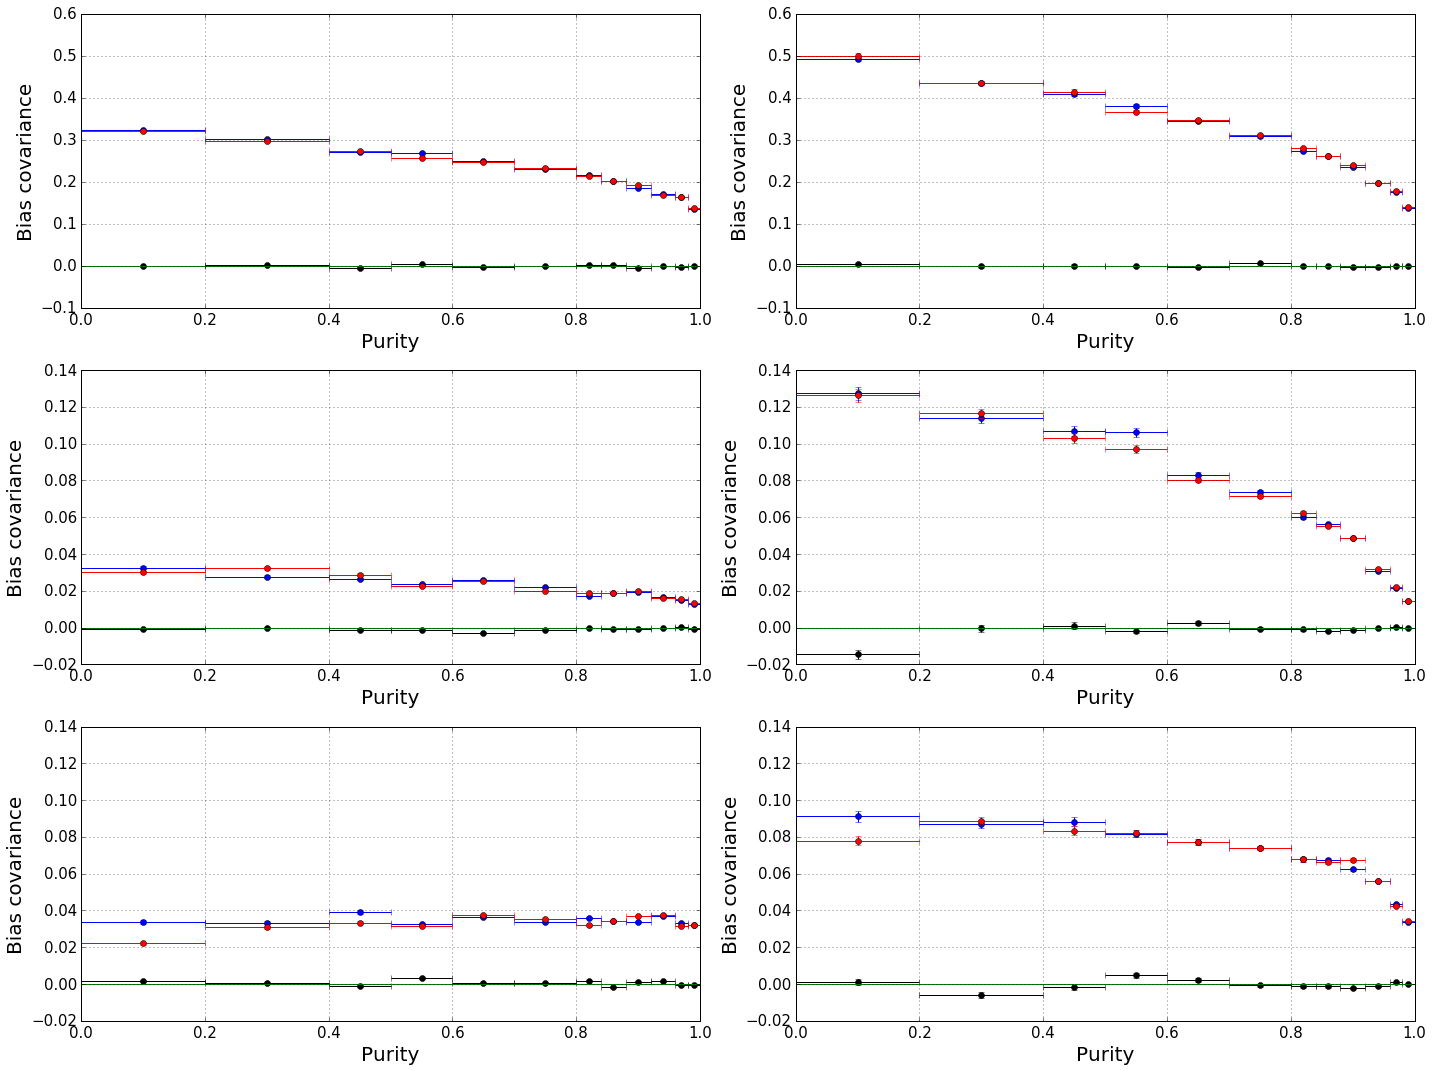

In [21]:
purity_bias_shears(cat,good,gold)

### Cumulative histograms purity and grp_size

In [57]:
def cumulative_histograms(cat,good,gold):
    fig = plt.figure(figsize=(20,20))
    nrow,ncol = 3,2
    #
    plt.subplot(nrow,ncol,1)
    plt.hist(cat['grp_size'], histtype='step',bins=600,range=([0,600]),cumulative=True,normed=True)
    plt.xlabel('grp_size',fontsize=14)
    plt.xlim(1,50)
    plt.ylim(0,1.)
    plt.title('Cumulative histogram of grp_size for all galaxies',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=12)
    #
    plt.subplot(nrow,ncol,2)
    plt.hist(cat['purity'], bins=50,histtype='step',weights=np.ones_like(cat['purity'])/len(cat['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.title('Histogram of purity for all galaxies',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=12)
    #
    plt.subplot(nrow,ncol,3)
    plt.hist(good['grp_size'], histtype='step',bins=600,range=([0,600]),cumulative=True,normed=True)
    plt.xlabel('grp_size',fontsize=14)
    plt.xlim(1,50)
    plt.ylim(0,1.)
    plt.title('Cumulative histogram of grp_size for good galaxies',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=12)
    #
    plt.subplot(nrow,ncol,4)
    plt.hist(good['purity'], bins=50,histtype='step',weights=np.ones_like(good['purity'])/len(good['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.title('Histogram of purity for good galaxies',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=12)

    #
    plt.subplot(nrow,ncol,5)
    plt.hist(gold['grp_size'], histtype='step',bins=600,range=([0,600]),cumulative=True,normed=True)
    plt.xlabel('grp_size',fontsize=14)
    plt.xlim(1,50)
    plt.ylim(0,1.)
    plt.title('Cumulative histogram of grp_size for gold galaxies',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=12)
    #
    plt.subplot(nrow,ncol,6)
    plt.hist(gold['purity'], bins=50,histtype='step',weights=np.ones_like(gold['purity'])/len(gold['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.title('Histogram of purity for gold galaxies',fontsize=18)


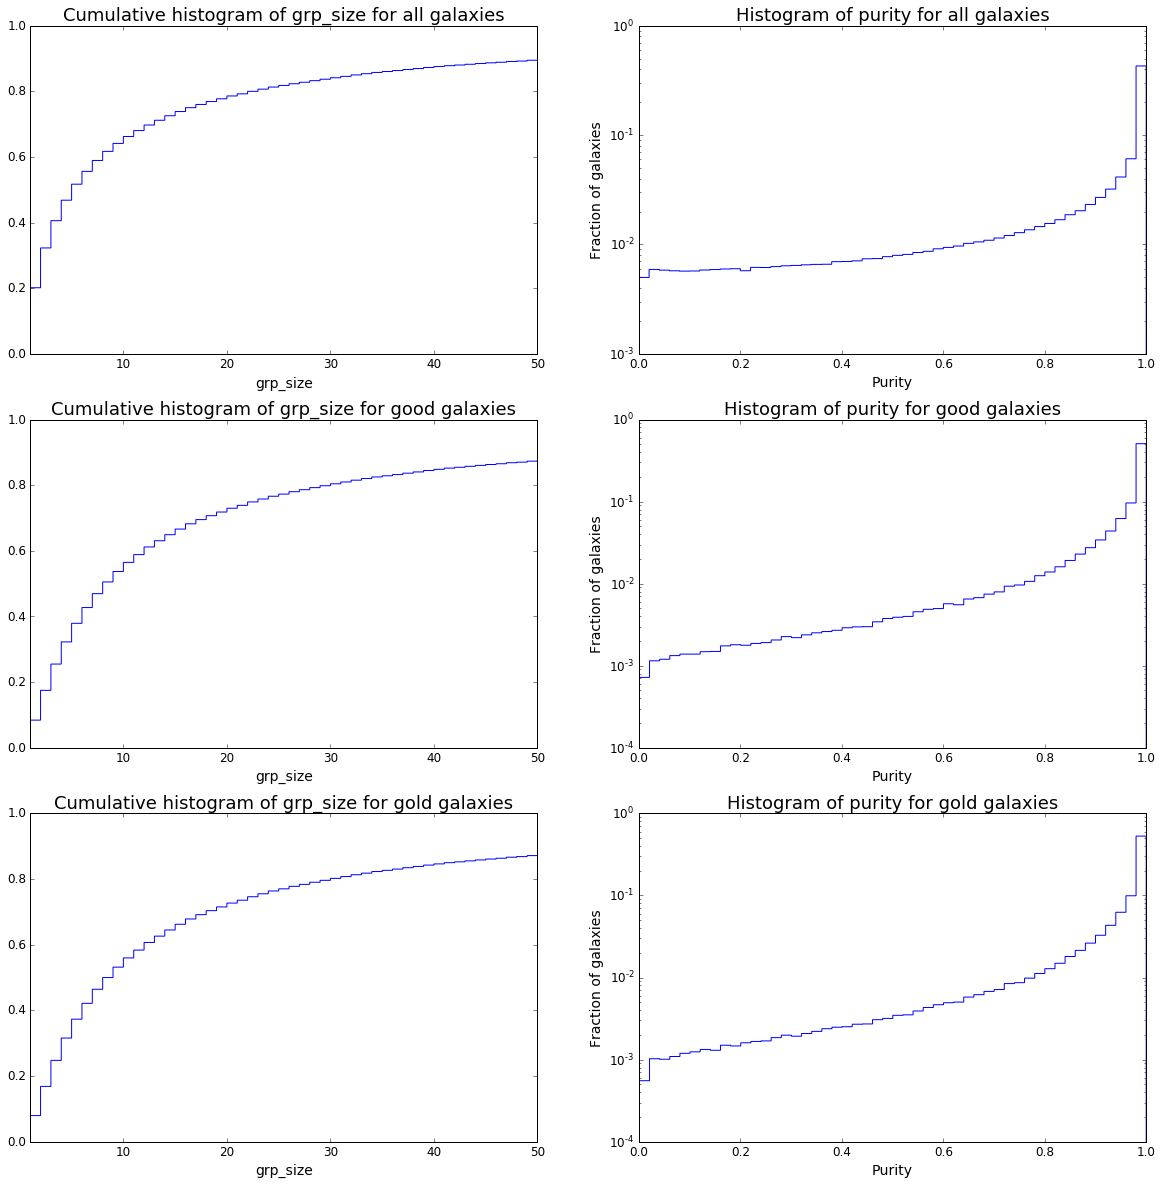

In [58]:
cumulative_histograms(cat,good,gold)

### Cumulative histograms purity and grp_size v2

In [48]:
def cumulative_histograms2(cat,good,gold):
    fig = plt.figure(figsize=(20,20))
    nrow,ncol = 2,1
    #
    plt.subplot(nrow,ncol,1)
    plt.hist(cat['grp_size'],histtype='step',bins=600,range=[0,600],color='red',label='all',cumulative=True,normed=True)
    plt.xlabel('grp_size',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.xlim(1,50)
    plt.ylim(0,1)
    plt.title('Cumulative histogram of grp_size',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15,width=2)
    #
    plt.hist(good['grp_size'],histtype='step',bins=600,range=([0,600]),label='good',color='blue',cumulative=True,normed=True)
    #
    plt.hist(gold['grp_size'],bins=600,range=([0,600]),histtype='step',label='gold',cumulative=True,color='gold',normed=True)
    plt.legend(loc=2,prop={'size':20})
    #
    #
    plt.subplot(nrow,ncol,2)
    plt.hist(cat['purity'], bins=50,histtype='step',color='red',label='all',weights=np.ones_like(cat['purity'])/len(cat['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.title('Histogram of purity',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=15)
    #
    plt.hist(good['purity'], bins=50,histtype='step',color='blue',label='good',weights=np.ones_like(good['purity'])/len(good['purity']))
    plt.xlabel('Purity',fontsize=14)
    plt.ylabel('Fraction of galaxies',fontsize=14)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=12,width=2)
    plt.tick_params(axis='both', which='minor',size=5)


    #
    plt.hist(gold['purity'], bins=50,histtype='step',color='gold',label='gold',weights=np.ones_like(gold['purity'])/len(gold['purity']))
    plt.xlabel('Purity',fontsize=18)
    plt.ylabel('Fraction of galaxies',fontsize=18)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=15)


    
    plt.legend(loc=2,prop={'size':20})



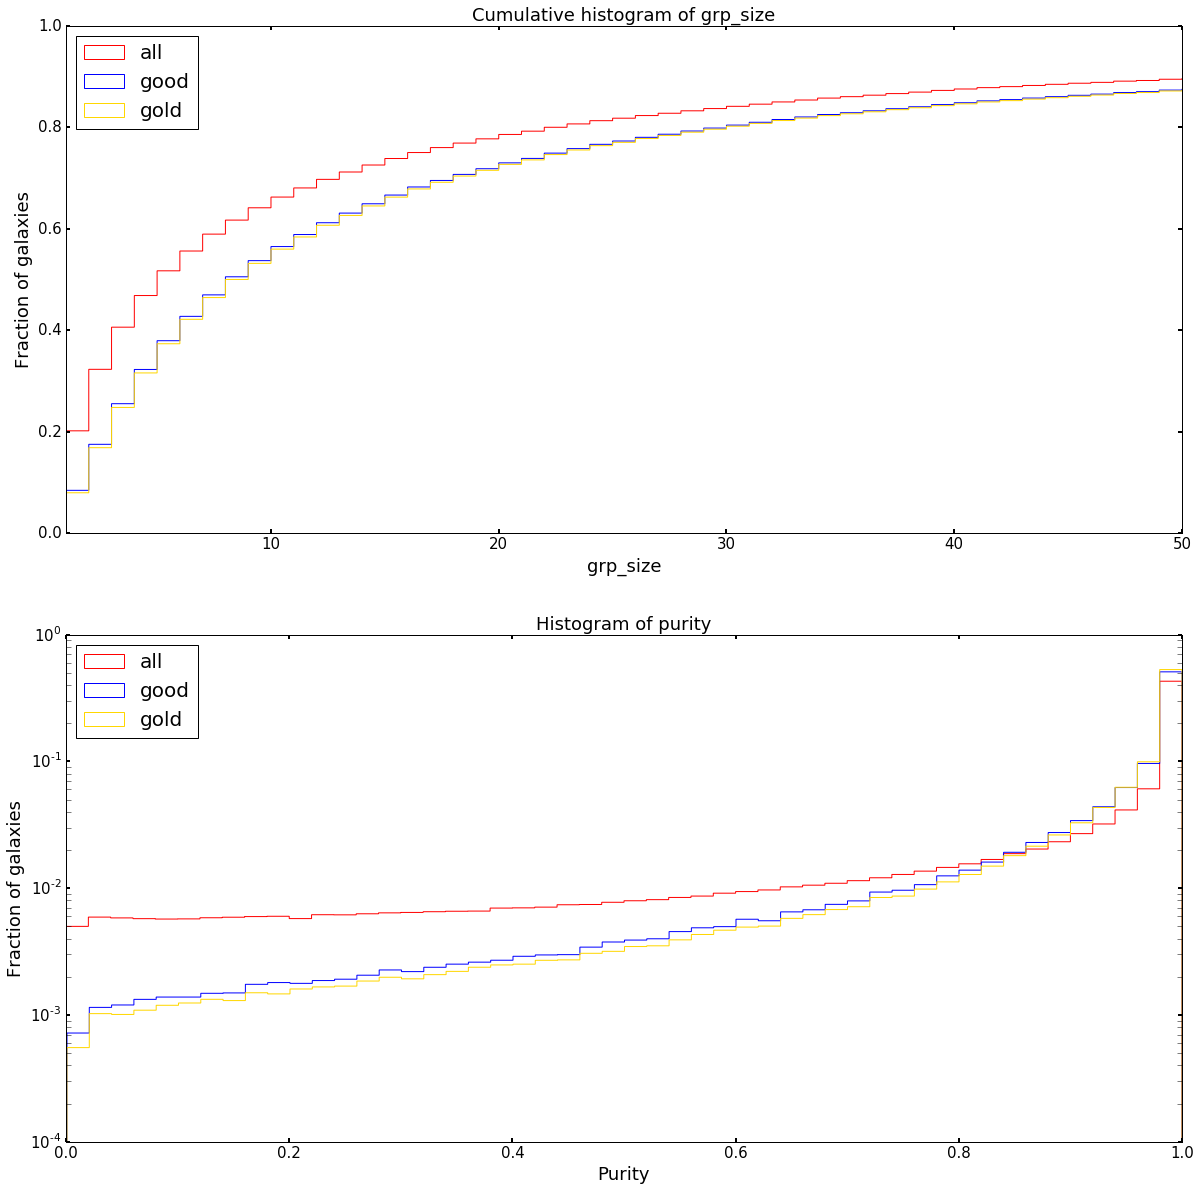

In [49]:
cumulative_histograms2(cat,good,gold)

### Scatter of purity and grp_size 

In [1]:
#what do we want to observe here? 
plt.scatter(cat['purity'],cat['grp_size'],alpha=.3)

NameError: name 'plt' is not defined

### Histograms of ab_mag

In [25]:
def histograms_abmag(cat,good):
    plt.figure()
    plt.hist(cat['ab_mag'], histtype='step', bins=50,label='all galaxies',range=(14,30))
    plt.xlabel('ab_mag',fontsize=14)
    plt.title('Histogram of ab_mag for all galaxies')
    plt.axvline(25.3,color='green',label='cut for golden sample') #this represents the gold sample cut. 
    #
    plt.hist(good['ab_mag'], histtype='step',bins=50,color='red',label='good galaxies',range=(14,30))
    plt.xlabel('ab_mag',fontsize=14)
    plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2)


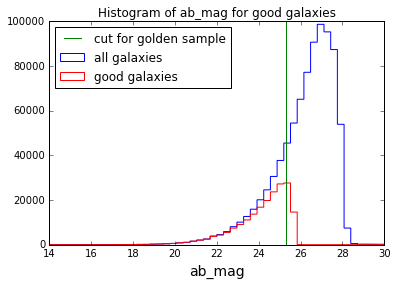

In [26]:
histograms_abmag(cat,good)

### Reason good and gold galaxies are less likely to be isolated than all galaxies 

In [12]:
#correlation of size and grp_size! 
print float(len(iso_gal[iso_gal['ab_mag'] >25.3]))/len(iso_gal)*100 
print float(len(grp_gal[grp_gal['ab_mag'] >25.3]))/len(grp_gal)*100

90.9823163454
73.6130501553


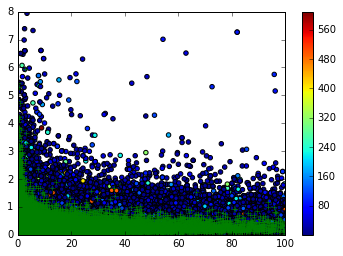

In [52]:
plt.scatter(cat['snr_iso'],cat['sigma_m'],c=cat['grp_size'])
plt.plot(iso_gal['snr_iso'],iso_gal['sigma_m'],'g+') 
plt.xlim(0,100)
plt.ylim(0,8)
plt.colorbar()
#this means that isolated galaxies are more likely to be dimmer and therefore 

### Fractional flux biases 

In [59]:
#similar plots but with bias on flux
def flux_biases_plots(good,gold,save=None):
    f_min = -3
    f_max = 3
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 1,2
    frac_bflux_g = good['bias_f']/good['flux']
    frac_bflux_grpg = good['bias_f_grp']/good['flux']
    frac_bflux_gold = gold['bias_f']/gold['flux']e
    frac_bflux_grpgold = gold['bias_f_grp']/gold['flux']
    #
    plt.subplot(nrow, ncol, 1) 
    plt.hist(frac_bflux_g,range=[f_min,f_max],bins=100,histtype='step',label='bias_f/flux')
    plt.hist(frac_bflux_grpg,range=[f_min,f_max],bins=100,color='red',histtype='step',label='bias_f_grp/flux')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on flux for good galaxies',fontsize=18)
    plt.xlabel('bias on flux/flux',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    #
    plt.subplot(nrow, ncol, 2) 
    plt.hist(frac_bflux_gold,range=[f_min,f_max],bins=100,histtype='step',label='bias_f/flux')
    plt.hist(frac_bflux_grpgold,range=[f_min,f_max],bins=100,color='red',histtype='step',label='bias_f_grp/flux')
    plt.legend()
    plt.yscale('log')
    plt.title('biases on flux for gold galaxies',fontsize=18)
    plt.xlabel('bias on flux/flux',fontsize=14)
    plt.ylabel('Number of galaxies',fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)


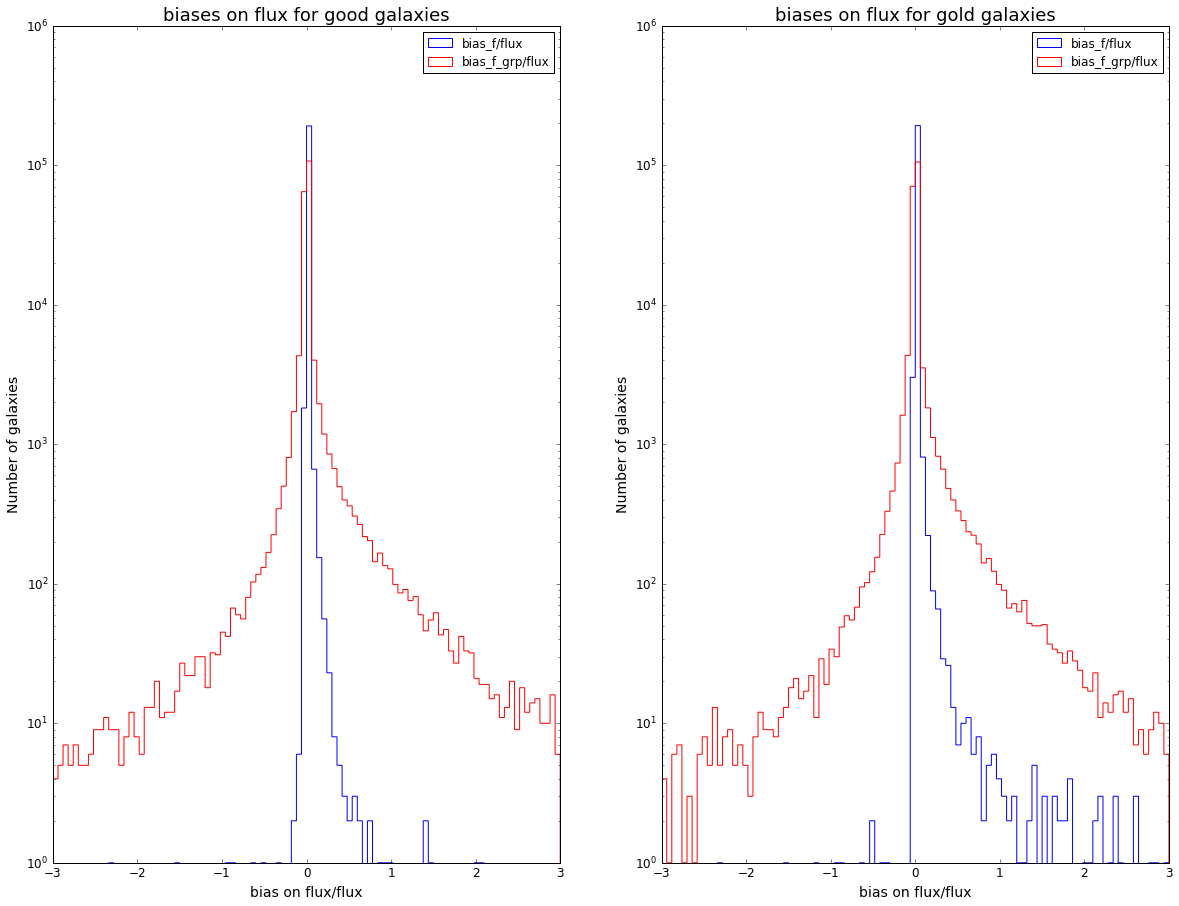

In [60]:
flux_biases_plots(good,gold)